In [1]:
import sys
sys.path.append('../src/')

# Dataset-based Simulator

In [2]:
import sqlite3
from opencem.dataset import *
from opencem.clock import Clock
from opencem.simulator import Simulator

In [3]:
clock = Clock.from_string("2026-01-03T10:00:00+08:00")
print(clock)

2026-01-03T02:00:00.000000000


In [4]:
dataset_db = sqlite3.connect("opencem_dataset.db")

In [5]:
inverter_id = 1
load = LoadDataset(clock, inverter_id, dataset_db)

In [6]:
bat = BatteryDataset(clock, inverter_id, dataset_db)
grid = GridDataset(clock, inverter_id, dataset_db)
power_source = PowerSourceDataset(clock, inverter_id, dataset_db)
inverter = InverterDataset(clock, inverter_id, dataset_db)
context = ContextDataset(clock,
                         48 * 60 * 60 * 10**9,
                         dataset_db)
simulator = Simulator(power_source, bat, load, grid, inverter, clock, context)

first_step = simulator.step(60 * 10**9)
initial_soc = first_step.battery.soc
print(first_step)

SimulatorStepResult(clock=Clock(ticks=1767405600000000000, RES=1000000000), battery=BatteryStepResult(voltage_v=np.float64(55.2), current_a=np.float64(0.7), soc=np.float64(1.0), discharge_capacity_c=np.float64(42.152727272727276), discharge_energy_j=np.float64(2318.4)), power_source=PowerSourceStepResult(voltage_v=np.float64(468.3538461538461), current_a=np.float64(0.9), power_w=np.float64(539.0)), load=LoadStepResult(current_a=np.float64(2.430769230769231), voltage_v=np.float64(229.9), power_apparent_va=np.float64(580.0769230769231), power_active_w=np.float64(406.38461538461536)), grid=GridStepResult(power_delivered_apparent_va=np.float64(0.0), power_delivered_active_w=np.float64(0.0)), inverter=InverterStepResult(next_battery_input=BatteryStepInput(mode=<BatteryStepMode.DISCHARGE: 2>, current_a=np.float64(0.7)), next_grid_input=GridStepInput(power_demand_apparent_va=np.float64(0.0), power_demand_active_w=np.float64(0.0)), generator_power_drawn_w=np.float64(539.0)), context=[ContextRe

In [7]:
import matplotlib.pyplot as plt

In [8]:
STEP_NS = 60 * 10**9
NUM_STEPS = 2400

results_ds = []
times_ds = []
soc_ds = []
power_src_w_ds = []
load_p_active_w_ds = []

context_entries = {}

for i in range(NUM_STEPS):
    res = simulator.step(STEP_NS)
    results_ds.append(res)
    times_ds.append(res.clock.to_numpy_datetime64())
    soc_ds.append(res.battery.soc * 100)
    power_src_w_ds.append(res.power_source.power_w)
    load_p_active_w_ds.append(res.load.power_active_w)
    for c in res.context:
        context_entries[c.recorded_at] = c

In [9]:
import pandas as pd

df_ds = pd.DataFrame({
    "time": times_ds,
    "battery_soc_percent": soc_ds,
    "power_source_power_w": power_src_w_ds,
    "load_power_active_w": load_p_active_w_ds,
})

df_ds.head()


,time,battery_soc_percent,power_source_power_w,load_power_active_w
0,2026-01-03 02:01:00,100.0,472.538462,390.846154
1,2026-01-03 02:02:00,100.0,440.692308,385.846154
2,2026-01-03 02:03:00,100.0,376.000000,365.250000
3,2026-01-03 02:04:00,100.0,419.083333,422.666667
4,2026-01-03 02:05:00,100.0,422.000000,380.333333


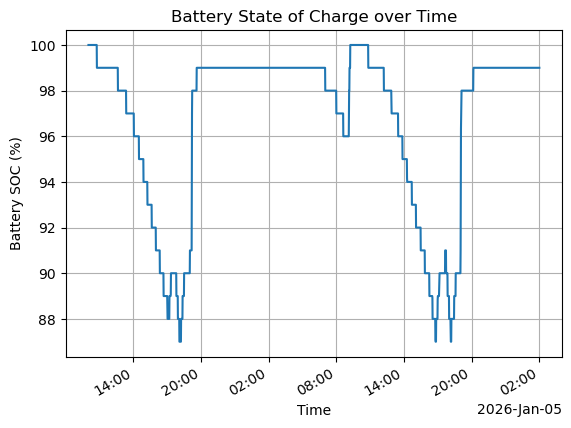

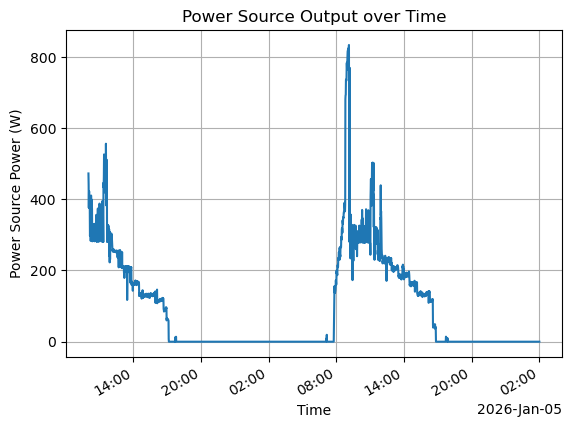

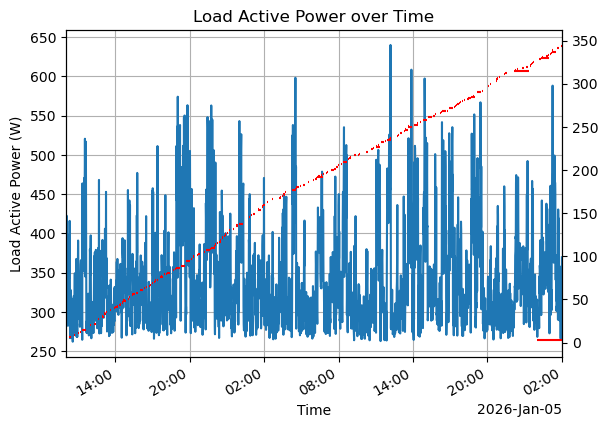

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


locator = mdates.AutoDateLocator(minticks=10, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator = locator, tz = "Asia/Shanghai")

plt.figure()
plt.plot(times_ds, df_ds["battery_soc_percent"])
plt.xlabel("Time")
plt.ylabel("Battery SOC (%)")
plt.title("Battery State of Charge over Time")
plt.grid(True)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=30, ha="right")

plt.figure()
plt.plot(times_ds, df_ds["power_source_power_w"])
plt.xlabel("Time")
plt.ylabel("Power Source Power (W)")
plt.title("Power Source Output over Time")
plt.grid(True)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=30, ha="right")

plt.figure()
plt.plot(times_ds, df_ds["load_power_active_w"])
plt.xlabel("Time")
plt.ylabel("Load Active Power (W)")
plt.title("Load Active Power over Time")
plt.grid(True)
plt.xlim(times_ds[0], times_ds[-1])
y2_ax = plt.twinx()
y2_y = 1
for recorded in context_entries:
    c = context_entries[recorded]
    y2_ax.hlines(y2_y, xmin=c.start.to_numpy_datetime64(),
                 xmax=c.end.to_numpy_datetime64(),
                 colors='red', linestyles='solid')
    #if c.source == 'opencem_team':
    #    y2_ax.text(c.start.to_numpy_datetime64(), y2_y, c.payload[0:(50 if y2_y == 1 else 26)]+"...", fontsize = 'small')
    y2_y = y2_y + 1
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=30, ha="right")


In [14]:
print(context_entries)

{Clock(ticks=1767404462000000000, RES=1000000000): ContextRecord(recorded_at=Clock(ticks=1767404462000000000, RES=1000000000), start=Clock(ticks=1767404462000000000, RES=1000000000), end=Clock(ticks=1767405717000000000, RES=1000000000), payload={'inverter': 1, 'source': 'workstation2_log', 'device': 'workstation2', 'task_type': 'CNN fitting, GPU load', 'model': 'swin_v2_s', 'optim': 'adam', 'dataset': 'CIFAR10', 'batch_size': 128, 'epochs': 2, 'model_params': 49737442, 'llm_estimated_task_effort': 'high', 'textual_description': 'The model swin_v2_s is fitted on CIFAR10 using adam for 2 epochs with bs=128.'}), Clock(ticks=1767400915000000000, RES=1000000000): ContextRecord(recorded_at=Clock(ticks=1767400915000000000, RES=1000000000), start=Clock(ticks=1767400915000000000, RES=1000000000), end=Clock(ticks=1767406011000000000, RES=1000000000), payload={'inverter': 1, 'source': 'workstation1_log', 'device': 'workstation1', 'task_type': 'compilation, CPU load', 'cpu_cores_active': '2', 'lib

In [ ]:
from opencem.linear import *

load = LoadDataset(clock, inverter_id, dataset_db)
bat = BatteryLinear(clock, initial_soc = 0.95)
grid = GridPriced(clock, max_power_active_w = 10**4)
power_source = PowerSourceDataset(clock, inverter_id, dataset_db)
inverter = InverterPVFirst(clock, min_soc = 0.05, max_soc = 0.95)
simulator = Simulator(power_source, bat, load, grid, inverter,
                      clock, context)

simulator.step(60 * 10**9)

In [ ]:
STEP_NS = 60 * 10**9
NUM_STEPS = 2400

results_lin = []
times_lin = []
soc_lin = []
power_src_w_ds = []
load_p_active_w_ds = []

for i in range(NUM_STEPS):
    res = simulator.step(STEP_NS)
    results_lin.append(res)
    times_lin.append(res.clock.to_numpy_datetime64())

    soc_lin.append(res.battery.soc * 100)
    power_src_w_ds.append(res.power_source.power_w)
    load_p_active_w_ds.append(res.load.power_active_w)

In [ ]:
df_lin = pd.DataFrame({
    "time": times_lin,
    "battery_soc_percent": soc_lin,
    "power_source_power_w": power_src_w_ds,
    "load_power_active_w": load_p_active_w_ds,
})

df_lin.head()

In [ ]:
plt.figure()
plt.plot(times_lin, df_ds["battery_soc_percent"])
plt.plot(times_lin, df_lin["battery_soc_percent"])
plt.xlabel("Time")
plt.ylabel("Battery SOC (%)")
plt.title("Battery State of Charge over Time")
plt.grid(True)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=30, ha="right")